# Grupo 1 - PCA em reconhecimento de dígitos

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import numpy as np
from tensorflow import keras
from keras import datasets
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
import copy

## Funções

#### PCA

In [ ]:
def PCA(B, confianca_alvo=0.9):
    
    #centrar os dados na média
    media = np.mean(B,0)
    phi = B - media
    
    #matriz de dispersão
    S = np.matmul(phi.T,phi)
    
    #vetores e valores próprios por ordem decrescente
    #(ou seja, primeiro aparecerá o maior valor próprio, depois o segundo maior...)
    
    val_prop_sc,vec_prop_sc = np.linalg.eigh(S)
    idx = np.argsort(val_prop_sc)
    val_prop_sc = val_prop_sc[idx]
    val_prop_sc = val_prop_sc[::-1]
    vec_prop_sc = vec_prop_sc[:,idx]
    vec_prop_sc = vec_prop_sc[::-1]
    
    
    #traço da matriz de dispersão (=soma de todos os val próprios)
    traco = np.sum(val_prop_sc)
    
    #cálculo do número de vetores próprios necessários para se atingir o nível de confiança pretendido
    #por defeito, a confiança_alvo está a 90%
    k = 0
    confianca = 0
    while confianca < confianca_alvo:
        confianca = confianca + val_prop_sc[k]/traco
        k += 1
     
    #desenho do scree plot (para aplicação do método de cotovelo)
    plt.figure(figsize = (10,10))
    t = np.arange(0, 784, 1)
    
    plt.plot(t, val_prop_sc, 'x')
    plt.plot(k, val_prop_sc[k], 'o')
    
    plt.show()
    
    #seleção das componentes principais
    val_prop_sc = val_prop_sc[:k]
    vec_prop_sc = vec_prop_sc[:k]
    
    return val_prop_sc, vec_prop_sc, k

#### Coeficientes de projeção

In [ ]:
def coef_proj (B, vec_prop_sc):
    coef_proj = np.matmul(B,vec_prop_sc.T)
    return coef_proj

#### Distância Euclidiana

In [ ]:
def distancia_euclidiana(v1, v2):
    v = np.subtract(v1, v2)
    v = np.power(v,2)
    return math.sqrt(sum(v))

#### Distância Mahalanobis

In [ ]:
def distancia_mahalanobis(v1, v2, val_prop_sc):
    m = len(val_prop_sc)
    v = np.zeros(m)    
    for i in range (m):
        v[i] = ((v1[i]-v2[i])**2)/val_prop_sc[i]
    return sum(v)

### Cálculo da distância entre imagens, retornando a mais próxima

A função seguinte retorna a label prevista pelas distâncias euclidiana e de mahalanobis, bem como o valor de cada uma delas. 

Retorna, ainda, um plot da nossa imagem de teste e das imagens mais próximas relativamente a cada distância.


In [ ]:
T_euclidiana = 500 
T_mahalanobis = 0.0003
def imagem_semelhante(input_img, vec_prop_sc, val_prop_sc, coef_proj):
    img = input_img
    gamma = np.array(input_img.flatten())
    test_phi = gamma - media
    test_coef_proj = np.dot(test_phi, vec_prop_sc.T)
    distEuc = [distancia_euclidiana(coef_proj[i], test_coef_proj) for i in range(60000)]
    prev_euclidiana = np.argmin(distEuc)
    
    distMah = [distancia_mahalanobis(coef_proj[i], test_coef_proj, val_prop_sc) for i in range(60000)]
    prev_mahalanobis =np.argmin(distMah)
    
    plt.title('Dígito de teste:')
    display(plt.imshow(img, cmap='gray'))
        
    f, ax = plt.subplots(1,2)
    
    if distEuc[prev_euclidiana] < T_euclidiana :
        print("Label prevista Distância Euclidiana:", int(train_labels[prev_euclidiana]))
        ax[0].set_title('Distância Euclidiana')
        ax[0].imshow(train_img[prev_euclidiana],cmap='gray')

    else:
        print("Dígito não reconhecido.")
        
    if distMah[prev_mahalanobis] < T_mahalanobis :
        print("Label prevista Distância Mahalanobis:", int(train_labels[prev_mahalanobis]))
        ax[1].set_title('Distância Mahalanobis')
        ax[1].imshow(train_img[prev_mahalanobis],cmap='gray')

    else:
        print("Dígito não reconhecido.")
    
    return prev_euclidiana, distEuc[prev_euclidiana], prev_mahalanobis, distMah[prev_mahalanobis]

### Precisão do algoritmo usando ambas as distâncias

In [ ]:
def semelhante_euclidiana(test_phi, vec_prop_sc, coef_proj):
    test_coef_proj = np.dot(test_phi, vec_prop_sc.T)
    distEuc = [distancia_euclidiana(coef_proj[n], test_coef_proj) for n in range(60000)]
    prev_euclidiana = np.argmin(distEuc)
    return prev_euclidiana, distEuc[prev_euclidiana]

def semelhante_mahalanobis(test_phi, vec_prop_sc, val_prop_sc, coef_proj):
    test_coef_proj = np.dot(test_phi, vec_prop_sc.T)
    distMah = [distancia_mahalanobis(test_coef_proj, coef_proj[n],  val_prop_sc) for n in range(60000)]
    prev_mahalanobis = np.argmin(distMah)
    return prev_mahalanobis, distMah[prev_mahalanobis]

In [ ]:
def accuracy(input_img, test_labels, train_labels, vec_prop_sc, val_prop_sc, coef_proj, media, m):
    T_euclidiana = 500 
    T_mahalanobis = 0.0003
    input_img = test_img[:m]
    certosEuc = 0
    certosMah = 0
    i = 0
    for i in range(m):
        img = input_img[i]
        img = img.flatten() - media
                
        prev_euclidiana = semelhante_euclidiana(img, vec_prop_sc, coef_proj)
        prev_mahalanobis = semelhante_mahalanobis(img, vec_prop_sc, val_prop_sc, coef_proj)
        #b = imagem_semelhante(test_img, vec_prop_sc, val_prop_sc, coef_proj)
        
        if train_labels[prev_euclidiana[0]] == test_labels[i] and prev_euclidiana[1] < T_euclidiana:
            certosEuc += 1
        if train_labels[prev_mahalanobis[0]] == test_labels[i] and prev_mahalanobis[1] < T_mahalanobis:
            certosMah += 1
        i += 1
        
    print("A accuracy do nosso algoritmo com " + str(m) + " imagens de teste foi de " + str(float(certosEuc)/m*100) + "%" + " para a distância Euclidiana e de " + str(float(certosMah)/m*100) + "%" + " para a distancia de Mahalanobis. ")

### Matriz de Confusão de cada distância

In [ ]:
def matriz_confusão_euclidiana(m,vec_prop_sc,coefs_proj):
    input_img = test_img[:m]
    predict = []
    for i in range(m):
        img = input_img[i]
        img = img.flatten() - media
                
        pred = semelhante_euclidiana(img, vec_prop_sc, coefs_proj)
        predict = np.append(predict, train_labels[pred[0]])
    confusion_mtx = confusion_matrix(test_labels[:m], predict)

    #plot

    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(confusion_mtx, annot = True, fmt = 'd', ax = ax, cmap = 'icefire')
    ax.set_xlabel('Dígito Previsto')
    ax.set_ylabel('Dígito Real')
    ax.set_title('Matriz de Confusão Distância Euclidiana');
    
def matriz_confusão_mahalanobis(m,vec_prop_sc,val_prop,coefs_proj):
    input_img = test_img[:m]
    predict = []
    for i in range(m):
        img = input_img[i]
        img = img.flatten() - media
                
        pred = semelhante_mahalanobis(img, vec_prop_sc, val_prop, coefs_proj)
        predict = np.append(predict, train_labels[pred[0]])
    confusion_mtx = confusion_matrix(test_labels[:m], predict)

    #plot

    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(confusion_mtx, annot = True, fmt = 'd', ax = ax, cmap = 'icefire')
    ax.set_xlabel('Dígito Previsto')
    ax.set_ylabel('Dígito Real')
    ax.set_title('Matriz de Confusão Distância Mahalanobis');

## Aplicação do PCA nos dados MNIST

### Importação da base de dados MNIST

In [ ]:
(train_img, train_labels),(test_img, test_labels) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


#### Primeiras 10 imagens da base de dados de teste

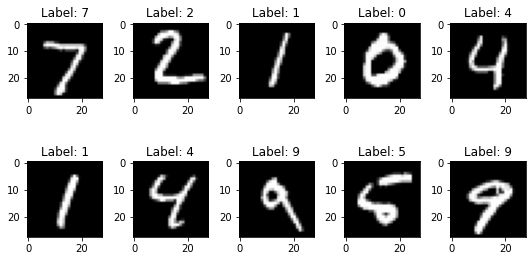

In [ ]:
num = 10
images = test_img[:num]
labels = test_labels[:num]
num_row = 2
num_col =5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

### Redimensionamento da matriz B

In [ ]:
B = np.array([train_img[i].flatten() for i in range(len(train_img))])
B.shape

(60000, 784)

Dados centrados na média

In [ ]:
media = np.mean(B,0)
phi = B - media

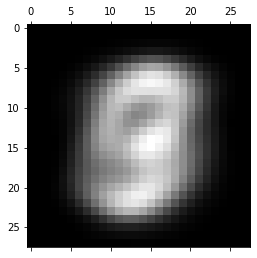

In [ ]:
display(plt.matshow(np.reshape(media,(28,28)),cmap = 'gray')) #imagem da média de todas as imagens

### Imagem inicial vs imagem centrada

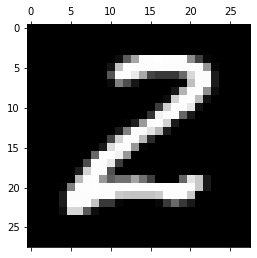

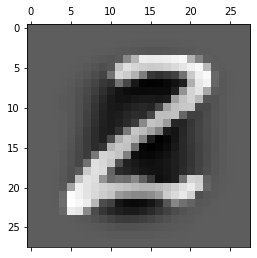

In [ ]:
display(plt.matshow(np.reshape(B[51001],(28,28)),cmap = 'gray'))
display(plt.matshow(np.reshape(phi[51001],(28,28)),cmap = 'gray'))


### Execução da função PCA

Como mencionado acima, decidimos considerar como confiança padrão 90%

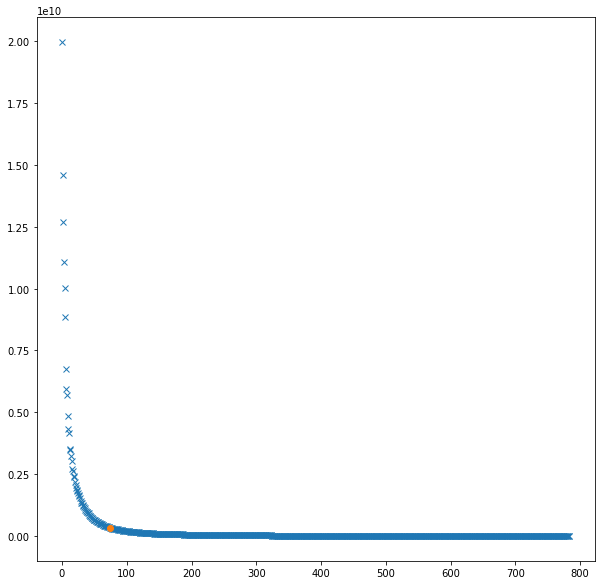

Número de componentes principais a utilizar: 74


In [ ]:
val_prop, vec_prop, k = PCA(B,0.88)

print("Número de componentes principais a utilizar:",k)

In [ ]:
val_prop.shape, vec_prop.shape

((74,), (74, 784))

#### Ilustração das 50 primeiras componentes principais

In [ ]:
e_faces, sigma, v = np.linalg.svd(phi.transpose(), full_matrices=False)
e_faces.shape

(784, 784)

<function matplotlib.pyplot.show(*args, **kw)>

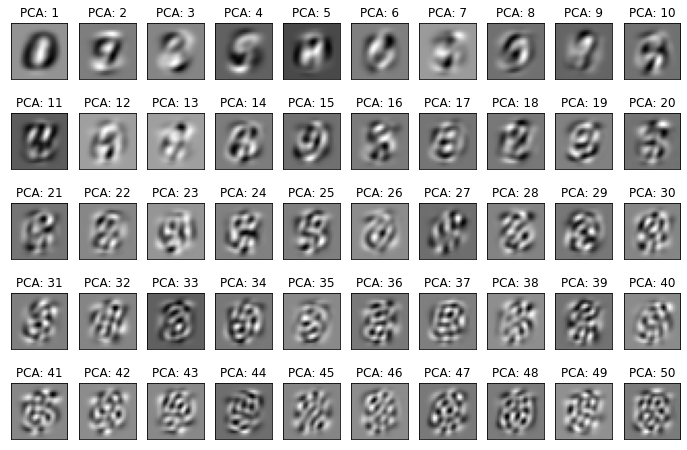

In [ ]:
fig = plt.figure(figsize = (12, 8))
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks = [], yticks = [])
    plot=ax.imshow(np.reshape(e_faces.T[i], (28,28)), cmap = "gray") 
    ax.set_title('PCA: {}'.format(i+1))
plt.show

### Matriz dos coeficientes de projeção (função coef_proj)

In [ ]:
coefs_proj = coef_proj(phi, vec_prop)
coefs_proj.shape

(60000, 74)

### Definição de tolerâncias máximas

In [ ]:
Lim_euclidiana = [semelhante_euclidiana((test_img[r].flatten())-media, vec_prop, coefs_proj) for r in range(100)]

In [ ]:
distsE = list(zip(*Lim_euclidiana))[1]
distsE = np.array(distsE)
min(distsE), max(distsE)

(66.80966747930101, 469.06431620237635)

In [ ]:
Lim_mahalanobis = [semelhante_mahalanobis((test_img[r].flatten())-media, vec_prop, val_prop, coefs_proj) for r in range(100)]

In [ ]:
distsM = list(zip(*Lim_mahalanobis))[1]
distsM = np.array(distsM)
min(distsM), max(distsM)

(5.730405508082969e-06, 0.000274271598612188)

### Aplicação do reconhecimento de dígitos ao dataset MNIST

##### Exemplo 1

In [ ]:
input_img = test_img[4]
test_labels[4]

4

In [ ]:
input_img.shape

(28, 28)

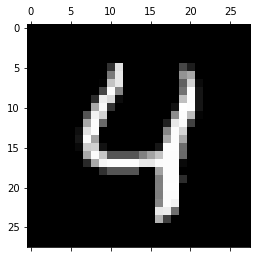

In [ ]:
display(plt.matshow(test_img[4], cmap='gray'))

Aplicamos agora a função imagem_semelhante à imagem de teste escolhida, 4



Label prevista Distância Euclidiana: 4
Label prevista Distância Mahalanobis: 4


(24734, 307.7029127670756, 40094, 0.00010883238888608591)

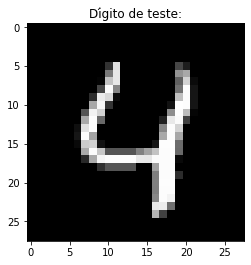

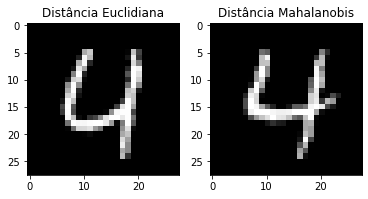

In [ ]:
imagem_semelhante(input_img, vec_prop, val_prop, coefs_proj)

Ambas as distâncias reconheceram corretamente o dígito 4

#### Exemplo 2

In [ ]:
input_img1 = test_img[9100]
test_labels[9100]

3

Label prevista Distância Euclidiana: 3
Label prevista Distância Mahalanobis: 3


(59471, 232.05637538457583, 59471, 6.0518917194754424e-05)

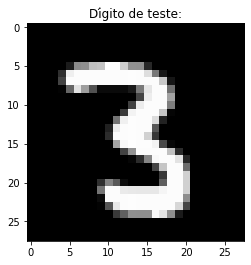

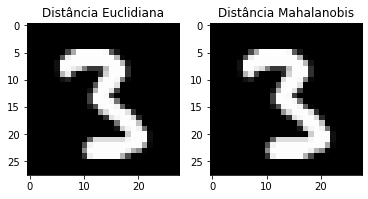

In [ ]:
imagem_semelhante(input_img1, vec_prop, val_prop, coefs_proj)

Uma vez mais, ambas as distâncias reconheceram corretamente o dígito 3

#### Função para cortar dígitos

In [ ]:
def separa_imagens (imagem) :
  imagem=imagem.T
  k=0
  j=0
  z=0
  #Este código vai cortar uma imagem quando detecta que existem dois digitos, o corte ocorre no fim do primeiro digito
  for i in range (28):
    if sum(imagem[i])==7140:
      k+=1
    if sum(imagem[i])!=7140:
      j+=1
      z=i-j
    if z!=0 and j+z<i:
      cort1=imagem[:i]
      cort2=imagem[i:]
      break
  return cort1,cort2

In [ ]:
def conta_imagens (imagem) :
    k=0
    # Após cortar uma imagem vamos contar quantas linhas vazias existem na imagem para sabermos como fazer o nosso padding.
    for i in range (len(imagem)):
      if sum(imagem[i])==7140:
        k+=1
    return k


In [ ]:
def colorir_imagensL (imagem) :
  k=0
  j=0
  colorir=imagem
  #O primeiro digito de cada imagem apenas vai ter linhas brancas à sua esquerda(output da função separa), o segundo digito
  # vai ter em ambos os lados, para contar as linhas brancas primeiro calculamos as da esquerda e depois
  #com esta função pintamos um ponto de cada linha da esquerda,restam agora apenas linhas brancas na direita
  # que contamos com a função anterior mais uma vez
  for i in range (len(imagem)):
    if sum(imagem[i])==7140:
      k+=1
    if sum(imagem[i])!=7140:
      break
    if sum(colorir[i])==7140:
      colorir[i][i]=5
  return colorir

In [ ]:
def padingimg1 (pad,esq,direita):
  k1=esq
  padding=np.pad(pad,([0,k1],[0,0]), 'constant', constant_values=255)
  #Começamos agora a fazer padding, devido ao corte que fizemos as imagens deixam de ser (28x28), o padding vai restaurar isto
  #Esta função vai se destinar ao primeiro digito, que vai ter sempre apenas linhas brancas do lado esquerdo, e adiciona o mesmo número
  # de linhas brancas no lado direito
  return padding

In [ ]:
def padingimg2 (padd,k1,k2):
    if k2<=k1:
      while k2<k1:
        padd=np.pad(padd,([0,1],[0,0]), 'constant', constant_values=255)
        k2+=1
    if k1<k2:
      while k1<k2:
        padd=np.pad(padd,([1,0],[0,0]), 'constant', constant_values=255)
        k1+=1
        # Este padding destina-se apenas á imagem dois, consoante existam mais linhas brancas do lado esquerdo(k1) ou do lado direito(k2) da imagem 
        # o codigo vai adicionar linhas brancas até k1=k2
    return padd


In [ ]:
def pading2 (pad2):
  k=pad2.shape[0]
  while k<28:
    pad2=np.pad(pad2,([0,1],[0,0]), 'constant', constant_values=255)
    k+=1
    if k<28:
      pad2=np.pad(pad2,([1,0],[0,0]), 'constant', constant_values=255)
      k+=1
    # Esta função vai pegar num digito com o mesmo numero de linhas brancas do lado esquerdo e do lado direito (ambos os digitos devem 
    # estar neste formato após o respetivo padding) e vai adicionar alternadamente uma linha branca em cada lado até obter uma imagem (28x8)
  return pad2

In [ ]:
def imagem_semelhante2(input_img, vec_prop_sc, val_prop_sc, coef_proj):
    img = input_img
    gamma = np.array(input_img.flatten())
    test_phi = gamma - media
    test_coef_proj = np.dot(test_phi, vec_prop_sc.T)
    distEuc = [distancia_euclidiana(coef_proj[i], test_coef_proj) for i in range(60000)]
    prev_euclidiana = np.argmin(distEuc)
    
    distMah = [distancia_mahalanobis(coef_proj[i], test_coef_proj, val_prop_sc) for i in range(60000)]
    prev_mahalanobis =np.argmin(distMah)
    if distEuc[prev_euclidiana] < T_euclidiana :
      a= int(train_labels[prev_euclidiana])
    else:
      a= "[ERRO]"
    if distMah[prev_mahalanobis] < T_mahalanobis :
      b=int(train_labels[prev_mahalanobis])
    else:
      b="[ERRO]"
    #esta função é a função imagem_semelhante original com pequenas alterações para apenas dar output das labels
    return a,b

In [ ]:
def reconhecer_digitos(imagem):
    from skimage.transform import resize
    image = np.array(Image.open(f"{imagem}.png"))
    image = image[:, :, 0]
    sep=separa_imagens(image)
    imagem1=sep[0]
    imagem2=sep[1]
    imagem2=255-imagem2     # esta inversão existe apenas para o if funcionar e é revertida no primeiro passo do else
    if int(sum(sum(imagem2)))==0:
      # Este primeiro if vai servir para distingir entre uma imagem com apenas 1 digito ou com 2 digitos
      # Após efetuar separa_imagens numa imagem com apenas um digito vamos obter duas imagens, a primeira um digito e a segunda uma imagem vazia
      # se a soma de todos os valores na imagem 2 for 0 quer dizer que é uma imagem vazia, detetamos assim que existe apenas 1 digito e não efetuamos qualquer tratamento na imagem
      #Caso contrário passamos para o Else
      image=255-image
      Euc3=imagem_semelhante2(image, vec_prop, val_prop, coefs_proj)[0]
      Mal3=imagem_semelhante2(image, vec_prop, val_prop, coefs_proj)[1]
      print(f"Número por distância Euclideana: {Euc3}")
      print(f"Número por distância Mahalanobis: {Mal3}")
    else:
      #Estamos agora no caso onde temos 2 digitos numa imagem
        imagem2=255-imagem2  #Começamos por inverter as cores da imagem2 para anular a inversão inicial
        k1=conta_imagens(imagem2) #Calcular o número de linhas brancas na esquerda da imagem 2
        im2copy=copy.deepcopy(imagem2) #Este copy é necessário para a seguinte função não afetar a imagem2 permanentemente
        colorir=colorir_imagensL(im2copy)#Colorimos as linhas brancas da esquerda da imagem 2 para poder contar as do lado direito
        k2=conta_imagens(im2copy)#Linhas brancas do lado direito da imagem 2
        k3=conta_imagens(imagem1)# Linhas brancas do lado esquerdo da imagem 1( que só tem linhas brancas no lado esquerdo)
        im1P1=padingimg1(imagem1,k3,0) #imagem 1 fase do padding 1
        im1P2=pading2(im1P1) # imagem 1 fase do padding 2
        im2P1=padingimg2(imagem2,k1,k2)
        im2P2=pading2(im2P1)
        im1P2= 255-im1P2 # inverter as imagens pois os nossos desenhos estão o oposto das imagens de treino
        im2P2= 255-im2P2 
        Euc1=imagem_semelhante2(im1P2.T, vec_prop, val_prop, coefs_proj)[0] #Label da imagem 1 por Distancia Euclideana 
        Euc2=imagem_semelhante2(im2P2.T, vec_prop, val_prop, coefs_proj)[0] #Label da imagem 1 por Distancia Mahalanobis
        Mal1=imagem_semelhante2(im1P2.T, vec_prop, val_prop, coefs_proj)[1] #Label da imagem 2 por Distancia Euclideana 
        Mal2=imagem_semelhante2(im2P2.T, vec_prop, val_prop, coefs_proj)[1] #Label da imagem 2 por Distancia Mahalanobis
        print(f"Número por distância Euclideana: {Euc1}{Euc2}")
        print(f"Número por distância Mahalanobis: {Mal1}{Mal2}")
        image=(im1P2.T,im2P2.T)
    return image

### Exemplos de dígitos criados por nós

#### Exemplo 1: Digito 8

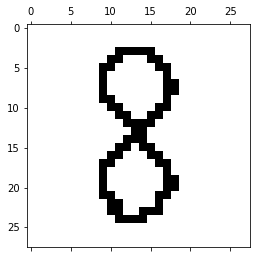

In [ ]:
image = np.array(Image.open("8.png"))
display(plt.matshow(image, cmap='gray'))

In [ ]:
resultado1=reconhecer_digitos(8)

Número por distância Euclideana: 8
Número por distância Mahalanobis: 8


Label prevista Distância Euclidiana: 8
Label prevista Distância Mahalanobis: 8


(20774, 374.5621877473974, 20774, 0.00011253278226605103)

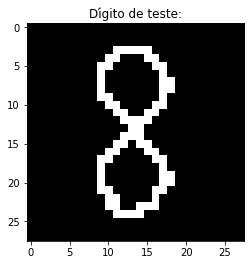

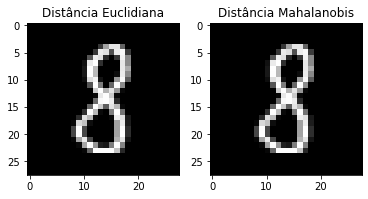

In [ ]:
imagem_semelhante(resultado1, vec_prop, val_prop, coefs_proj)

#### Exemplo 2: Número 13

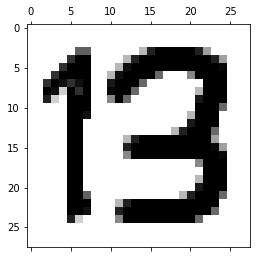

In [ ]:
image = np.array(Image.open("13.png"))
display(plt.matshow(image, cmap='gray'))

In [ ]:
resultado2=reconhecer_digitos(13)

Número por distância Euclideana: 13
Número por distância Mahalanobis: 1[ERRO]


Label prevista Distância Euclidiana: 1
Label prevista Distância Mahalanobis: 1


(33663, 241.73449094771783, 33663, 7.384083111240746e-05)

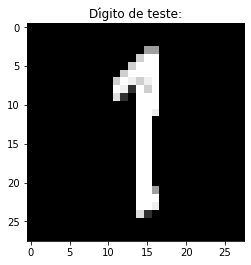

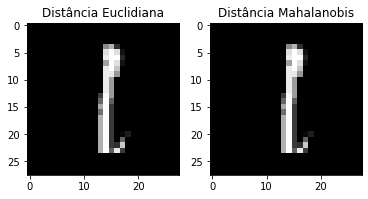

In [ ]:
imagem_semelhante(resultado2[0], vec_prop, val_prop, coefs_proj)

Label prevista Distância Euclidiana: 3
Dígito não reconhecido.


(4878, 421.0463211340313, 21812, 0.00031069049529746116)

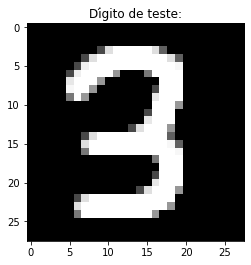

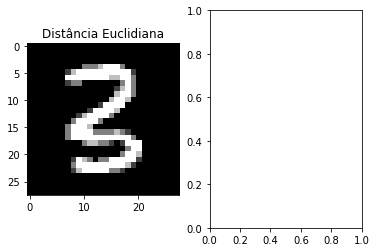

In [ ]:
imagem_semelhante(resultado2[1], vec_prop, val_prop, coefs_proj)

#### Exemplo 3: Número 24

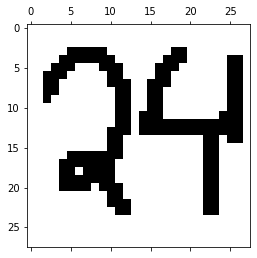

In [ ]:
image = np.array(Image.open("24.png"))
display(plt.matshow(image, cmap='gray'))

In [ ]:
resultado3=reconhecer_digitos(24)

Número por distância Euclideana: 24
Número por distância Mahalanobis: 24


Label prevista Distância Euclidiana: 2
Label prevista Distância Mahalanobis: 2


(32654, 324.45795883631826, 32654, 0.00014616216787720403)

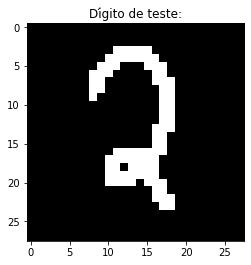

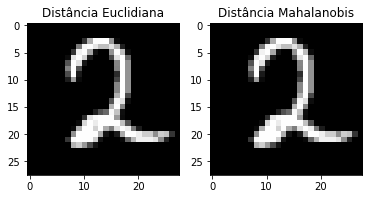

In [ ]:
imagem_semelhante(resultado3[0], vec_prop, val_prop, coefs_proj)

Label prevista Distância Euclidiana: 4
Label prevista Distância Mahalanobis: 4


(32458, 373.7933860309533, 32458, 0.00014805504114550054)

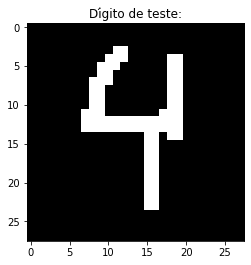

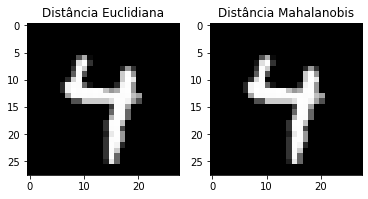

In [ ]:
imagem_semelhante(resultado3[1], vec_prop, val_prop, coefs_proj)

#### Exemplo 4: Erro

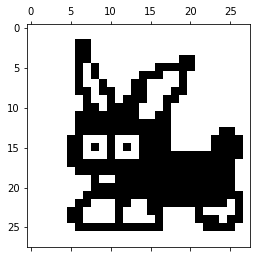

In [ ]:
image = np.array(Image.open("erro1.png"))
display(plt.matshow(image, cmap='gray'))

In [ ]:
resultado4=reconhecer_digitos("erro1")

Número por distância Euclideana: [ERRO]
Número por distância Mahalanobis: [ERRO]


Dígito não reconhecido.
Dígito não reconhecido.


(56564, 660.2285757947164, 46164, 0.0005510945840959136)

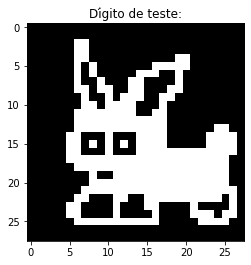

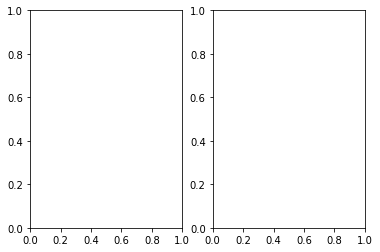

In [ ]:
imagem_semelhante(resultado4, vec_prop, val_prop, coefs_proj)

### Dados de teste

#### Matriz de Confusão relativa à distância euclidiana

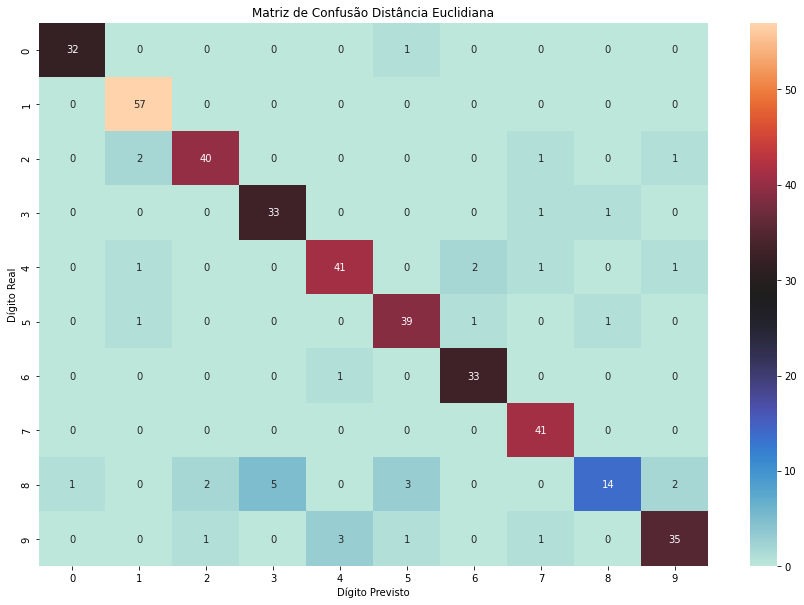

In [ ]:
matriz_confusão_euclidiana(400,vec_prop,coefs_proj)

#### Matriz de Confusão relativa à distância de mahalanobis

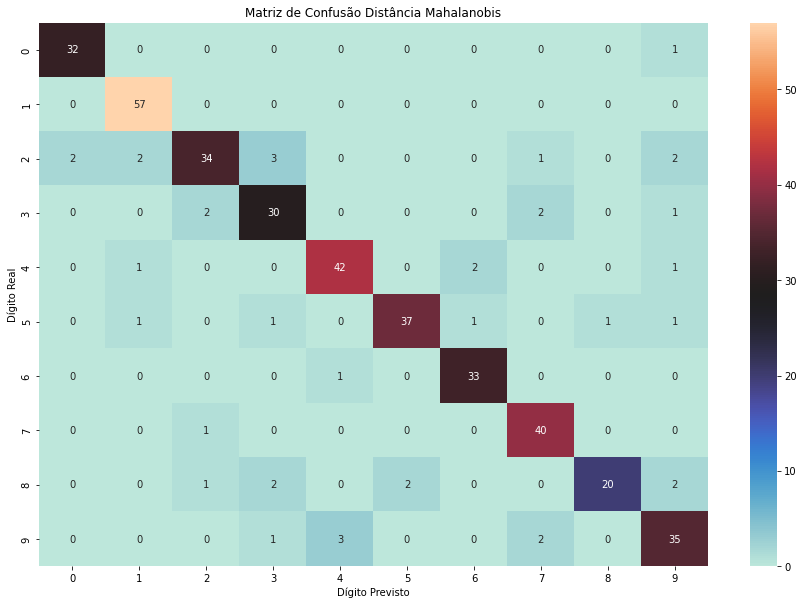

In [ ]:
matriz_confusão_mahalanobis(400,vec_prop,val_prop,coefs_proj)

#### Accuracy do algoritmo

In [ ]:
n_img=500
accuracy(test_img, test_labels, train_labels, vec_prop, val_prop, coefs_proj, media, n_img)

A accuracy do nosso algoritmo com 500 imagens de teste foi de 90.8% para a distância Euclidiana e de 88.6% para a distancia de Mahalanobis. 
